---
#**Disaster tweets or not disaster tweets NLP project**
---


```
Project prepared by Stephanie Cotineau - #dsmpt-Paris-08
```



In [1]:
# Import librairies

from google.colab import files
import pandas as pd
import io

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

In [2]:
!pip install spacy -q

In [3]:
!python -m spacy download en_core_web_sm -q

     |████████████████████████████████| 12.8 MB 4.6 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
import re

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV

# **Train data & Test data - Exploratory Data Analysis**

---


## > Import Train data & check Train data quality

---

In [5]:
# Select file where to upload train data

data_to_load = files.upload()

Saving train.csv to train.csv


In [6]:
# Import train data

train = pd.read_csv(io.BytesIO(data_to_load['train.csv']))

In [7]:
# Visualize first rows of train data

train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
train.shape

(7613, 5)

In [9]:
train.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


In [10]:
# Check missing values

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [11]:
# Count of missing data

total = train.isnull().sum().sort_values(ascending=False)

# Percentage of missing data

percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
location,2533,0.332720
keyword,61,0.008013
id,0,0.000000
text,0,0.000000
target,0,0.000000


## > Focus on the differents' "features"
---




1.   Location
---



In [12]:
# Location

train['location'].value_counts(ascending = False).head(55)

USA                  104
New York              71
United States         50
London                45
Canada                29
Nigeria               28
UK                    27
Los Angeles, CA       26
India                 24
Mumbai                22
Washington, DC        21
Kenya                 20
Worldwide             19
Australia             18
Chicago, IL           18
California            17
Everywhere            15
New York, NY          15
California, USA       15
Florida               14
San Francisco         14
United Kingdom        14
Los Angeles           13
Indonesia             13
Washington, D.C.      13
Toronto               12
NYC                   12
Ireland               12
Seattle               11
Earth                 11
San Francisco, CA     11
Chicago               11
Texas                 10
London, England       10
Sacramento, CA        10
New York City         10
London, UK            10
Atlanta, GA           10
ss                    10
Dallas, TX             9


In [13]:
# Number of "unique" (written way) locations

location_train  = list(set(train['location']))
len(location_train)

3342

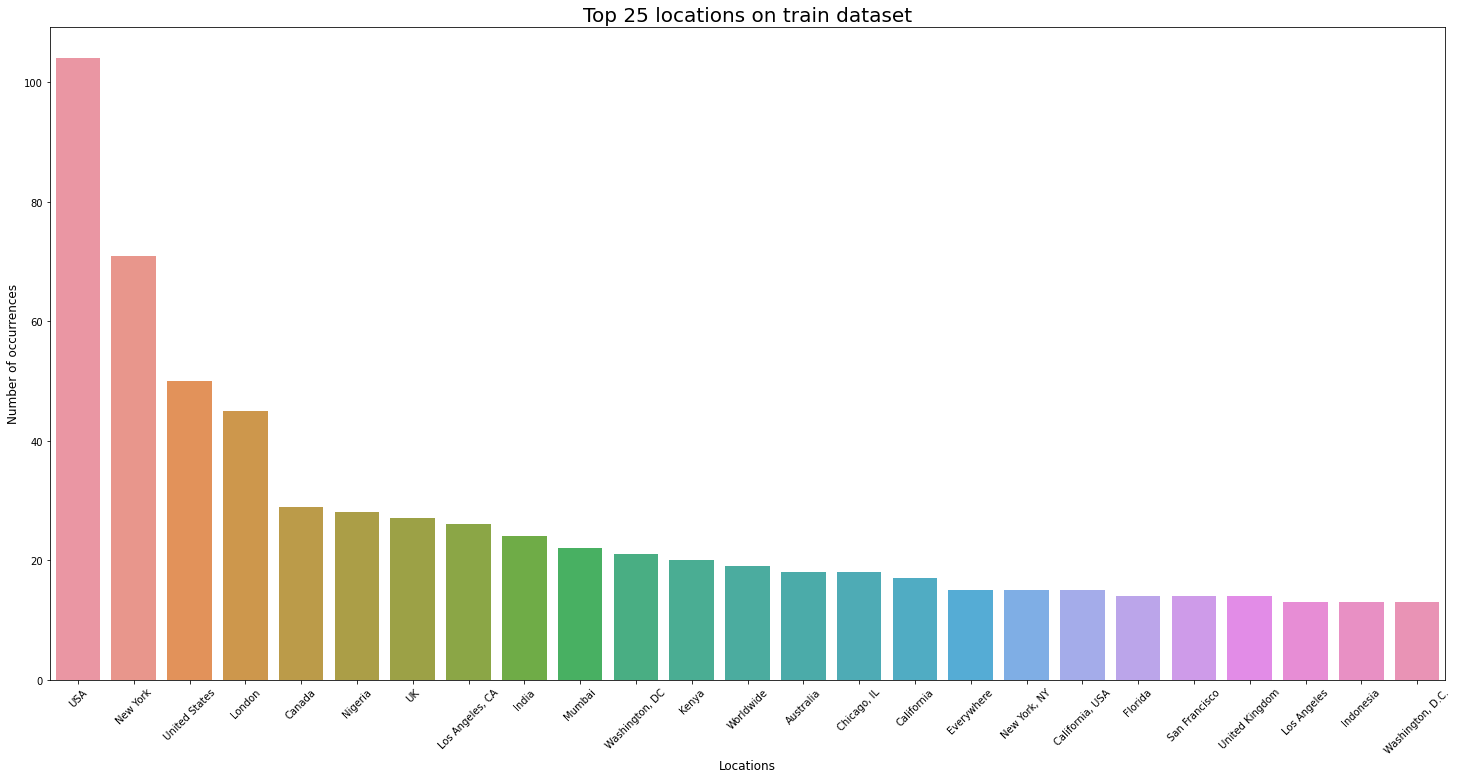

In [14]:
# Visualization of Top 25 locations

plt.figure(figsize=(25,12))
sns.barplot(x=train['location'].value_counts(ascending = False).head(25).index, y = train['location'].value_counts(ascending = False).head(25))
plt.title('Top 25 locations on train dataset', fontsize=20)
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Locations', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [15]:
# Recode cities/countries to countries

recode_cities = {
    "USA":"United States",
    "New York":"United States",
    "Los Angeles": "United States",
    "Los Angeles, CA":"United States",
    "Washington, DC": "United States",
    "San Francisco": "United States",
    "San Francisco, CA": "United States",
    "Chicago, IL": "United States",
    "Chicago": "United States",
    "New York, NY": "United States",
    "NYC": "United States",
    "Florida": "United States",
    "London": "UK",
    "United Kingdom": "UK",
    "Mumbai": "India",
    "California": "United States",
    "California, USA": "United States",
    "Toronto": "Canada",
    "Washington, D.C.": "United States",
    "Everywhere": "Worldwide",
    "Seattle": "United States",
    "Texas": "United States",
    "London, England": "UK",
    "Sacramento, CA": "United States",
    "New York City": "United States",
    "London, UK": "UK",
    "Atlanta, GA": "United States",
    "Dallas, TX": "United States",
    "San Diego, CA": "United States",
    "US": "United States",
    "Denver, Colorado": "United States",
    "Manchester": "UK",
    "World": "Worldwide",
    "Nashville, TN": "United States",
    "Scotland": "UK",
    "Houston, TX": "United States",
    "Denver, CO": "United States",
    "Tennessee": "United States",
    "Seattle, WA": "United States",
    "Sydney": "Australia",
    "Austin, TX": "United States",
    "ss": "Worldwide",
    "Earth": "Worldwide",
    "Pennsylvania, USA": "United States",
    "Memphis, TN": "United States",
    "worldwide": "Worldwide",
    "Orlando, FL": "United States",
    "Global": "Worldwide",
    "Colorado": "United States",
    "Atlanta": "United States",
    "Charlotte, NC": "United States",
    "Morioh, Japan": "Japan",
    "California, United States": "United States",
    "Portland, OR": "United States",
    "Calgary, Alberta": "Canada",
    "Brooklyn, NY": "United States",
    "Planet Earth": "Worldwide",
    "Massachusetts": "United States",
    "Oklahoma City, OK": "United States",
    "San Jose, CA": "United States",
    "Pennsylvania": "United States",
    "Lagos": "Nigeria",
    "Tampa, FL": "United States",
    "Texas, USA": "United States",
    "Boston, MA": "United States",
    "New Jersey": "United States",
    "Newcastle": "UK",
    "Vancouver, BC" : "Canada",
    "Leeds, England": "UK",
    "New Hampshire": "United States",
    "Cleveland, OH": "United States",
    "WorldWide": "Worldwide",
    "Asheville, NC": "United States",
    "Florida, USA": "United States",
    "Coventry": "UK"
}

train["countries"] = train["location"]

In [16]:
# Add recode countries in train dataset
train["countries"] = train["countries"].replace(recode_cities)
data = train["countries"].value_counts()
data

United States             675
UK                        138
Worldwide                  88
Canada                     52
India                      46
                         ... 
Memphis,TN/ World Wide      1
In My Lab Creating          1
Bronx NYC / M-City NY       1
Bikini bottom               1
Lincoln                     1
Name: countries, Length: 3266, dtype: int64

In [17]:
# Proportion of tweets per country - Top 10
df_countries = pd.DataFrame(data)
df_countries["percent"] = df_countries["countries"]/df_countries['countries'].sum()
df_countries.head(10)

,countries,percent
United States,675,0.132874
UK,138,0.027165
Worldwide,88,0.017323
Canada,52,0.010236
India,46,0.009055
Nigeria,33,0.006496
Australia,25,0.004921
Kenya,20,0.003937
Indonesia,13,0.002559
Ireland,12,0.002362


In [18]:
# Share of disaster tweets per country

df = train.drop(["id", "keyword", "location", "text"], axis = 1)

In [19]:
table = pd.pivot_table(df, index=['countries'], 
                    values=['target'], aggfunc=np.sum)
top_10=table["target"].sort_values(ascending=False).head(10)
top_10

countries
United States    313
UK                50
Worldwide         42
India             39
Nigeria           25
Canada            25
Australia         13
Indonesia          8
Ireland            6
Kenya              5
Name: target, dtype: int64

In [20]:
disaster_tweets_countries = pd.merge(left=df_countries.head(10), right=top_10, left_index=True, right_index=True)
disaster_tweets_countries = disaster_tweets_countries.drop(["percent"], axis = 1)
disaster_tweets_countries

,countries,target
United States,675,313
UK,138,50
Worldwide,88,42
Canada,52,25
India,46,39
Nigeria,33,25
Australia,25,13
Kenya,20,5
Indonesia,13,8
Ireland,12,6


In [21]:
disaster_tweets_countries["share_disaster_tweets"] = round(100 * disaster_tweets_countries["target"] / disaster_tweets_countries["countries"], 2)
disaster_tweets_countries.rename(columns={"countries" : "total_tweets", "target" : "disaster_tweets"}, inplace=True)
disaster_tweets_countries

,total_tweets,disaster_tweets,share_disaster_tweets
United States,675,313,46.37
UK,138,50,36.23
Worldwide,88,42,47.73
Canada,52,25,48.08
India,46,39,84.78
Nigeria,33,25,75.76
Australia,25,13,52.00
Kenya,20,5,25.00
Indonesia,13,8,61.54
Ireland,12,6,50.00


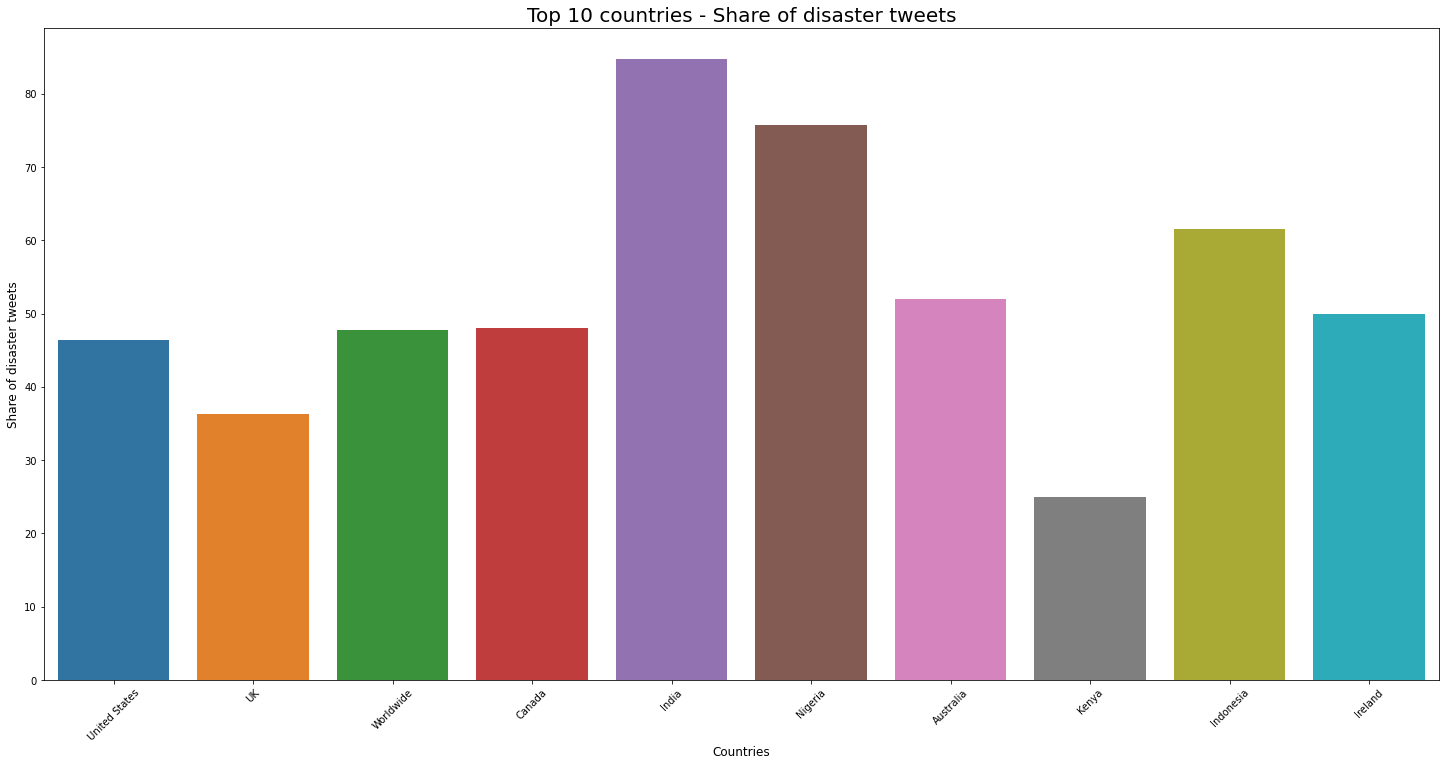

In [22]:
# Visualization of Top 10 countries share of disaster tweets
 
plt.figure(figsize=(25,12))
sns.barplot(x=disaster_tweets_countries.index, y = disaster_tweets_countries['share_disaster_tweets'])

plt.title('Top 10 countries - Share of disaster tweets', fontsize=20)
plt.ylabel('Share of disaster tweets', fontsize=12)
plt.xlabel('Countries', fontsize=12)
plt.xticks(rotation=45)
plt.show()



2.   Keyword
---


In [23]:
# Keywords

train['keyword'].value_counts(ascending = False).head(55)

fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
collided       40
siren          40
twister        40
windstorm      40
sinkhole       39
sunk           39
hellfire       39
weapon         39
weapons        39
famine         39
explosion      39
whirlwind      39
earthquake     39
derailment     39
wreckage       39
collision      39
flames         39
wrecked        39
oil%20spill    38
flooding       38
deaths         38
derailed       38
thunder        38
ambulance      38
drowned        38
explode        38
blaze          38
fatal          38
typhoon        38
fire           38
upheaval       38
hurricane      38
injury         38
bombed         38
panic          37
pandemonium    37
debris         37
blizzard       37
destroy        37
sandstorm      37
mudslide       37
ruin           37
quarantined    37
fatality       37
bioterror      37
Name: keyw

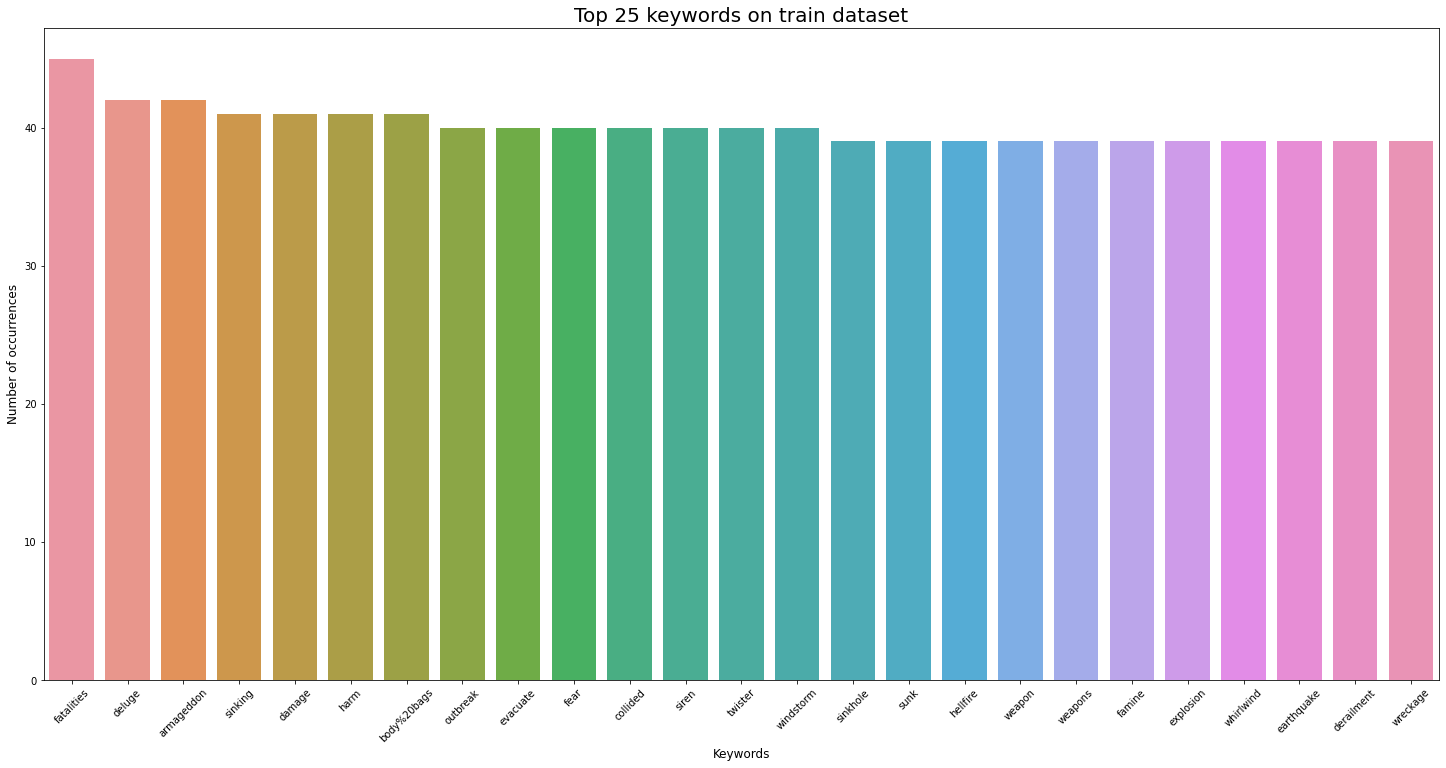

In [24]:
# Visualization of Top 25 keywords

plt.figure(figsize=(25,12))
sns.barplot(x=train['keyword'].value_counts(ascending = False).head(25).index, y = train['keyword'].value_counts(ascending = False).head(25))
plt.title('Top 25 keywords on train dataset', fontsize=20)
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Keywords', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [25]:
# Number of unique keywords

keyword_train  = list(set(train['keyword']))
len(keyword_train)

222

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


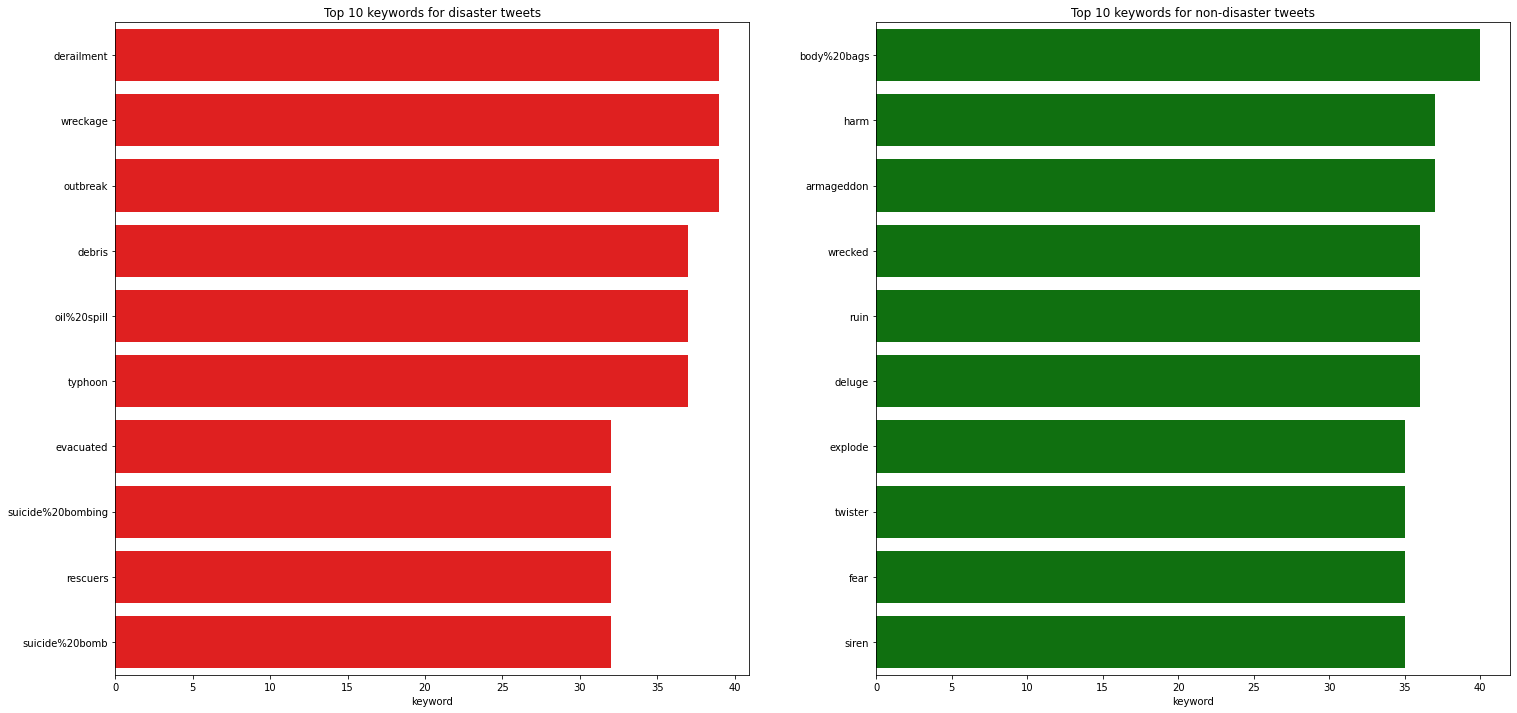

In [26]:
# Top keywords according to target:
# Top keywords disaster vs top keywords not disaster

keyword_disaster = train[train["target"]==1].keyword.value_counts().head(10)
keyword_not_disaster = train[train["target"]==0].keyword.value_counts().head(10)

plt.figure(figsize=(25,12))
plt.subplot(121)
sns.barplot(keyword_disaster, keyword_disaster.index, color='r')
plt.title('Top 10 keywords for disaster tweets')
plt.subplot(122)
sns.barplot(keyword_not_disaster, keyword_not_disaster.index, color='g')
plt.title('Top 10 keywords for non-disaster tweets')
plt.show()




3.   Text
---



In [27]:
# Text
# Tweet length analysis

def length(tweet):    
    return len(tweet)
train['tweet_length'] = train['text'].apply(length)

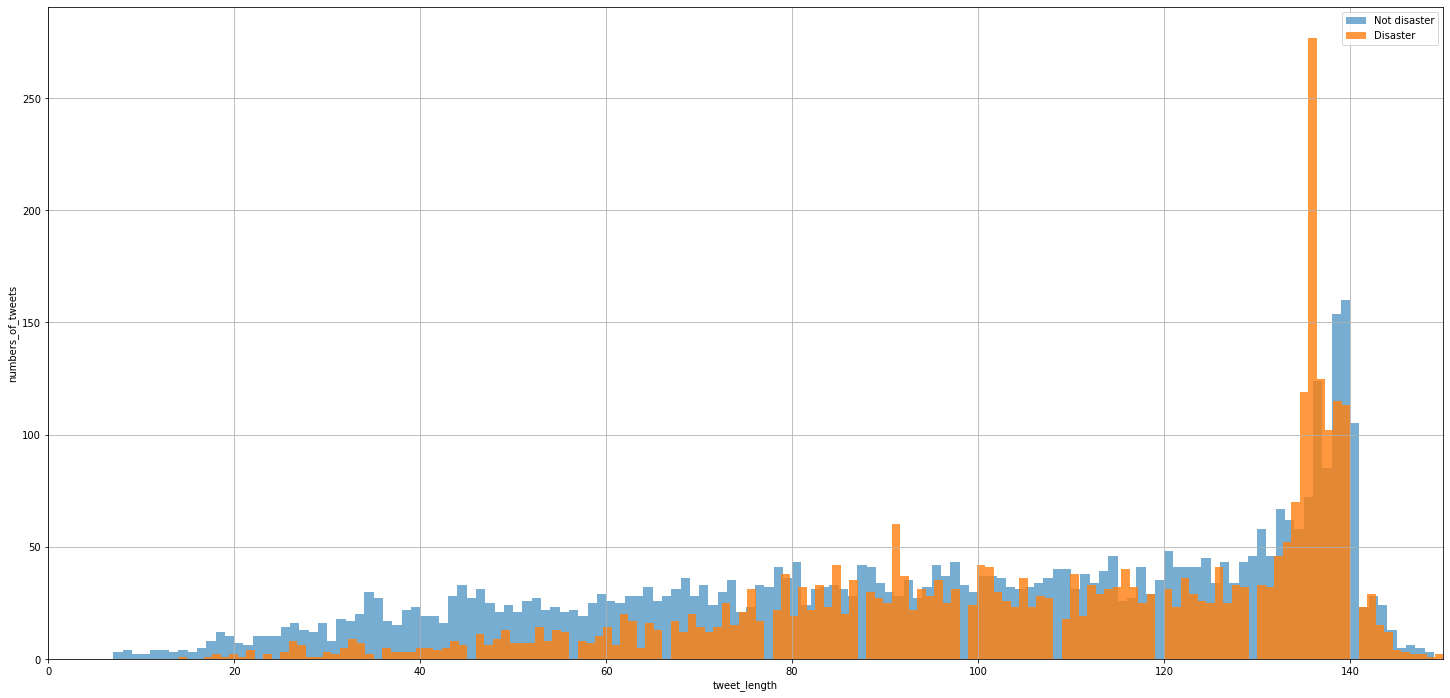

In [28]:
# Visualization of tweets' length (number of characters)

plt.figure(figsize=(25,12))
bins = 150
plt.hist(train[train['target'] == 0]['tweet_length'], alpha = 0.6, bins=bins, label='Not disaster')
plt.hist(train[train['target'] == 1]['tweet_length'], alpha = 0.8, bins=bins, label='Disaster')
plt.xlabel('tweet_length')
plt.ylabel('numbers_of_tweets')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


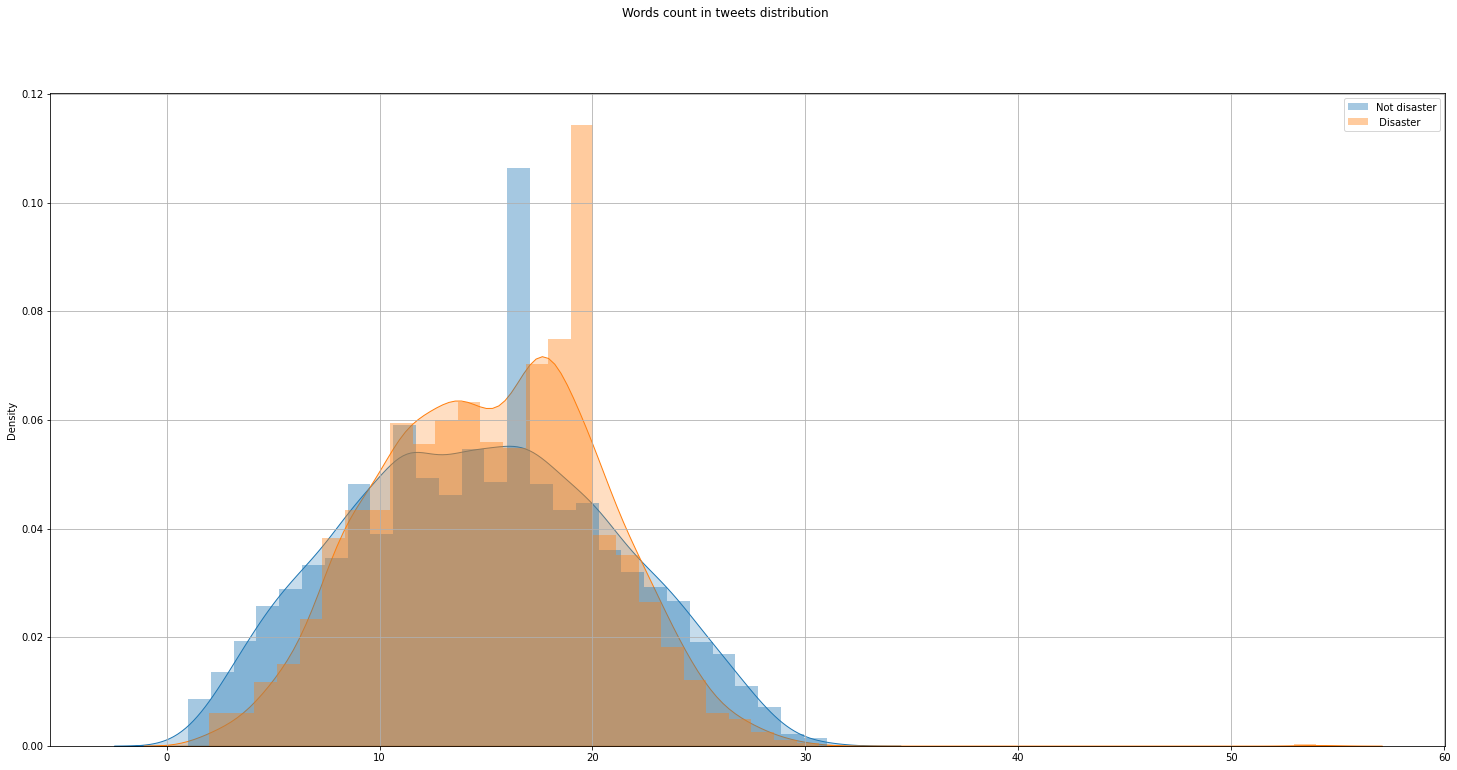

In [29]:
# Tweets words number distribution

plt.figure(figsize=(25,12))
train['word_count'] = train['text'].apply(lambda x: len(x.split(" ")))
sns.distplot(train[train['target'] == 0]['word_count'].values, hist=True, kde=True, kde_kws={"shade": True}, label='Not disaster')
sns.distplot(train[train['target'] == 1]['word_count'].values, hist=True, kde=True, kde_kws={"shade": True}, label=' Disaster')
plt.legend(loc='upper right')

plt.grid()
plt.suptitle("Words count in tweets distribution")
plt.show()

In [30]:
# Disaster tweets words number distribution
print("25th percentile: ", train[train['target'] == 1]['word_count'].describe()['25%'])
print("mean: ", train[train['target'] == 1]['word_count'].describe()['50%'])
print("75th percentile: ", train[train['target'] == 1]['word_count'].describe()['75%'])

25th percentile:  11.0
mean:  15.0
75th percentile:  19.0


In [31]:
# Not disaster tweets words number distribution
print("25th percentile: ", train[train['target'] == 0]['word_count'].describe()['25%'])
print("mean: ", train[train['target'] == 0]['word_count'].describe()['50%'])
print("75th percentile: ", train[train['target'] == 0]['word_count'].describe()['75%'])

25th percentile:  10.0
mean:  15.0
75th percentile:  19.0




4.   Target
---



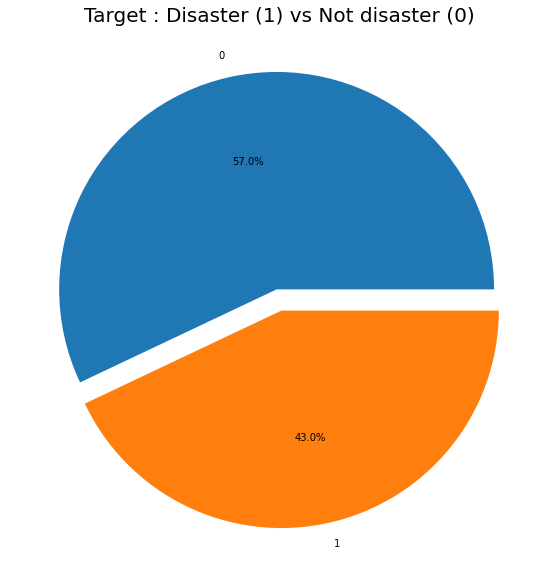

In [32]:
# Visualization of Target: 1 for disaster and 0 for not disaster

pie_chart_target = train['target'].value_counts()
plt.figure(figsize=(10,10))
plt.pie(pie_chart_target.values, labels = pie_chart_target.index, autopct = '%1.1f%%', explode=[0.05]*2)
plt.title("Target : Disaster (1) vs Not disaster (0)", fontsize = 20)
plt.show()

---
Key take away on train dataset features:
---
*   **Location**: the top 25 locations show a mix of countries and cities as United States and New York, Los Angeles, NY, New York... It also show several ways of writting a same place (USA, United States, Washington, D.C., Washington DC...). Among the 3342 locations, we have duplication because of misspelling. And we have one third (33%) of missing location among the total tweets.
*   **Keyword**: 222 keywords have been identified. Less than 1% of tweets haven't been manually coded with a keyword (missing keyword).
*   **Target**: the target (tweet disaster vs not tweet disaster) is slightly imbalanced, this could have an impact on the final classifier (classifier may be inclined to predict the predominant class, here "not disaster (0)").
---

## > Quick check 'features' on Test dataset 
---


In [33]:
# Select file where to upload test data

data_to_load = files.upload()

Saving test.csv to test.csv


In [34]:
# Import test data

test = pd.read_csv(io.BytesIO(data_to_load['test.csv']))

In [35]:
# Visualize first rows of test data

test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [36]:
test.shape


(3263, 4)

In [37]:
test.describe(include='all')

,id,keyword,location,text
count,3263.000000,3237,2158,3263
unique,NaN,221,1602,3243
top,NaN,deluged,New York,11-Year-Old Boy Charged With Manslaughter of T...
freq,NaN,23,38,3
mean,5427.152927,NaN,NaN,NaN
std,3146.427221,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN
25%,2683.000000,NaN,NaN,NaN
50%,5500.000000,NaN,NaN,NaN
75%,8176.000000,NaN,NaN,NaN


In [38]:
# Check missing values

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [39]:
# Count of missing data

total = test.isnull().sum().sort_values(ascending=False)

# Percentage of missing data

percent = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
location,1105,0.338645
keyword,26,0.007968
id,0,0.000000
text,0,0.000000




1.   Location
---



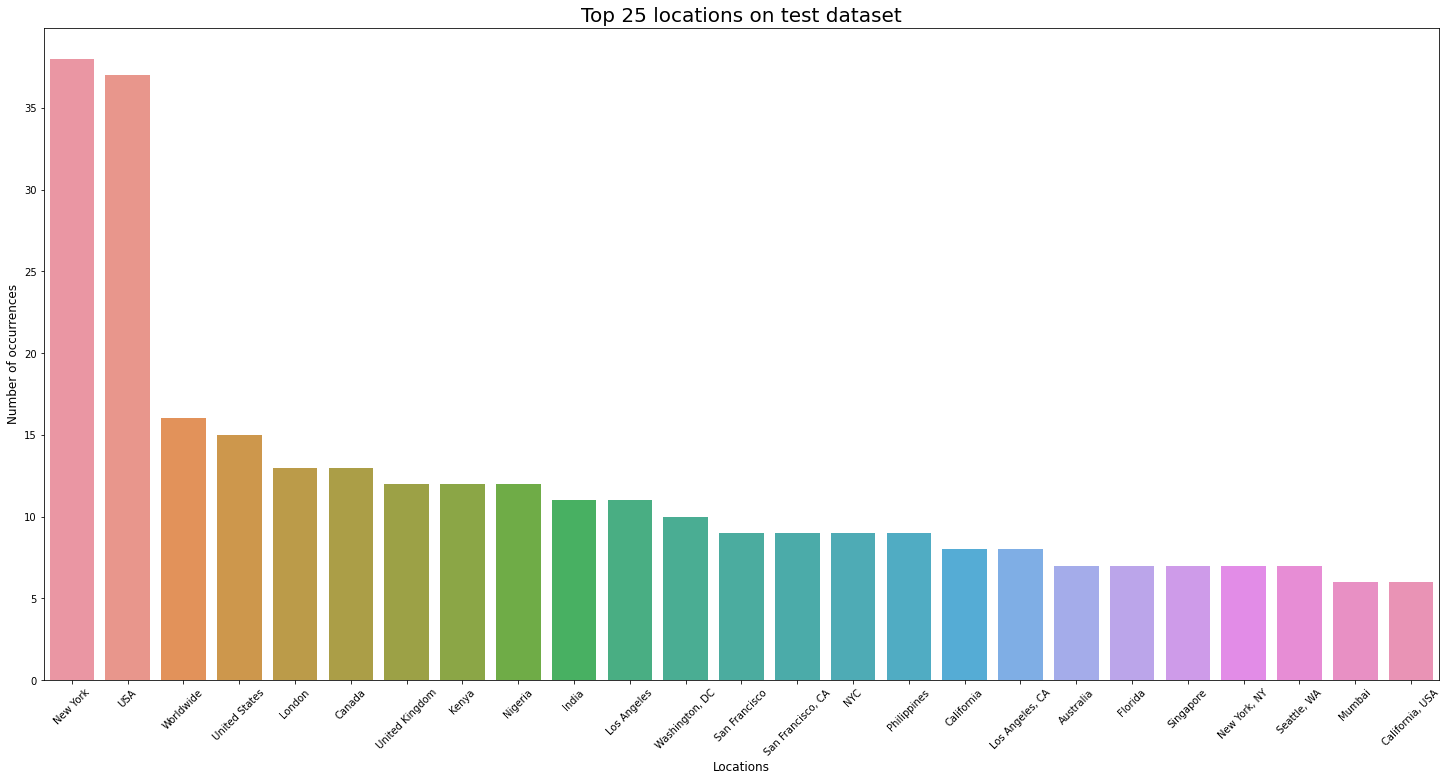

In [40]:
# Visualization of Top 25 locations on test dataset

plt.figure(figsize=(25,12))
sns.barplot(x=test['location'].value_counts(ascending = False).head(25).index, y = test['location'].value_counts(ascending = False).head(25))
plt.title('Top 25 locations on test dataset', fontsize=20)
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Locations', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [41]:
# Location comparison train vs test dataset

train_location = train['location'].value_counts(ascending = False).head(25).index
test_location = test['location'].value_counts(ascending = False).head(25).index

In [42]:
data = {'train_location' : train_location, 'test_location' : test_location}
train_test_location = pd.DataFrame(data, columns=['train_location','test_location'])
train_test_location

,train_location,test_location
0,USA,New York
1,New York,USA
2,United States,Worldwide
3,London,United States
4,Canada,London
5,Nigeria,Canada
6,UK,United Kingdom
7,"Los Angeles, CA",Kenya
8,India,Nigeria
9,Mumbai,India



2.   Keyword
---


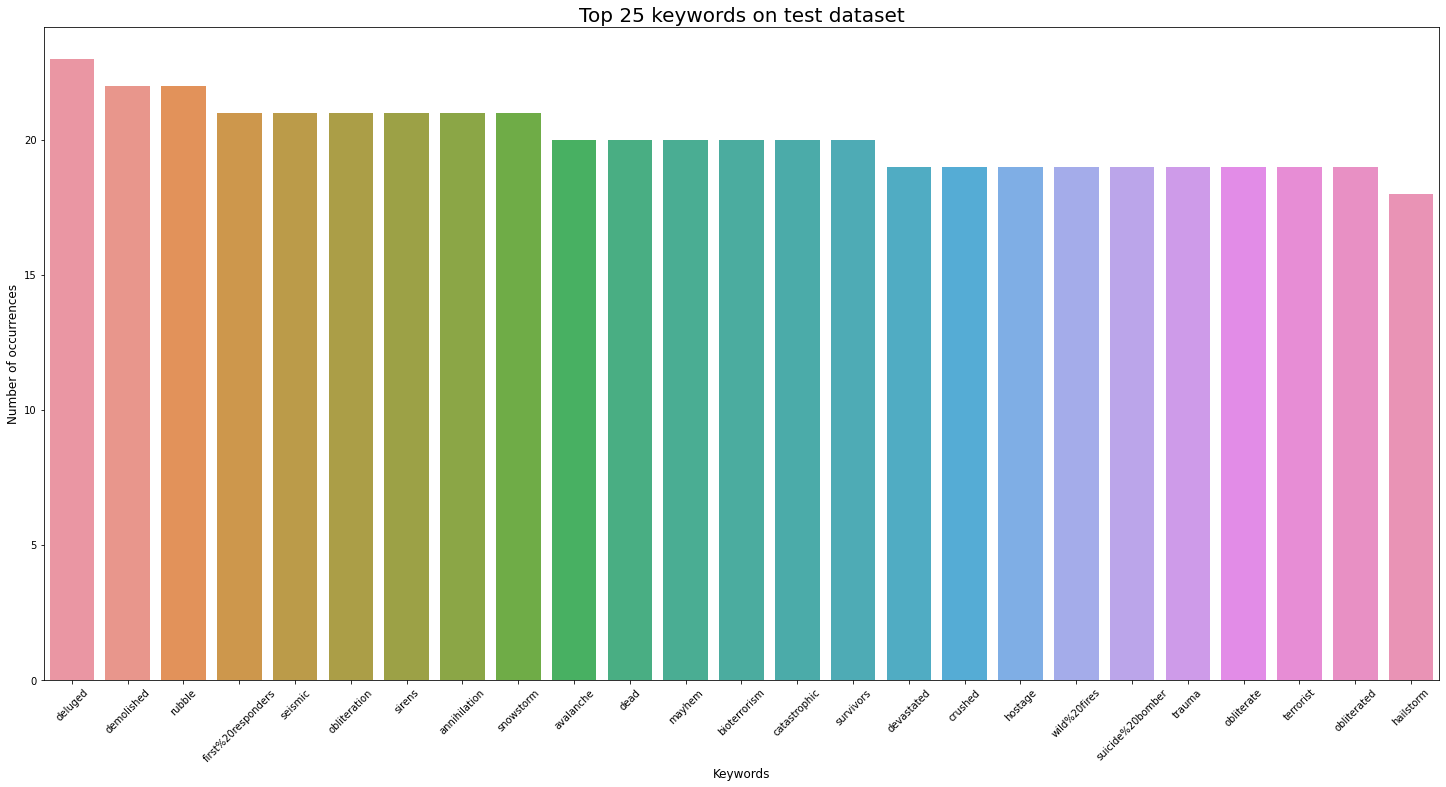

In [43]:
# Visualization of Top 25 keywords on test dataset

plt.figure(figsize=(25,12))
sns.barplot(x=test['keyword'].value_counts(ascending = False).head(25).index, y = test['keyword'].value_counts(ascending = False).head(25))
plt.title('Top 25 keywords on test dataset', fontsize=20)
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Keywords', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [44]:
# Number of unique keywords

keyword_test  = list(set(test['keyword']))
len(keyword_test)

222

In [45]:
# Keyword comparison train vs test dataset
train_keyword = train['keyword'].value_counts(ascending = False).head(25).index
test_keyword = test['keyword'].value_counts(ascending = False).head(25).index

In [46]:
data = {'train_keyword' : train_keyword, 'test_keyword' : test_keyword}
train_test_keyword = pd.DataFrame(data, columns=['train_keyword','test_keyword'])
train_test_keyword

,train_keyword,test_keyword
0,fatalities,deluged
1,deluge,demolished
2,armageddon,rubble
3,sinking,first%20responders
4,damage,seismic
5,harm,obliteration
6,body%20bags,sirens
7,outbreak,annihilation
8,evacuate,snowstorm
9,fear,avalanche


---
## Key take away on comparison test dataset vs train dataset:

*   The top 25 locations is almost the same between train and test, only Philippines and Singapore are in test top 25 and not in train top 25.
*   The keyword comparison show quite a different top 25 words between train and test dataset, not a lot of common words between both lists, even if we have the same number of keywords (222 on both).
---

# **Train dataset's preprocessing and data cleaning**

---


## > Undersampling to get balanced Train's "target" & drop useless columns
---

In [47]:
# Number of observation per target

train["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [48]:
new_train0=train[train['target']==0]
new_train1=train[train['target']==1]

In [49]:
new_train1.shape

(3271, 8)

In [50]:
new_train0.shape

(4342, 8)

In [51]:
# Generating randomly train target 0 sample with same size/number of observations of train target 1
new_train0=new_train0.sample(new_train1.shape[0]) 
new_train0.shape

(3271, 8)

In [52]:
# Aggregating balanced targets in new train dataframe 
new_train=pd.concat([new_train0,new_train1],axis=0)

In [53]:
# Shuffle lines/values of new_train dataset
from sklearn.utils import shuffle   
new_train = shuffle(new_train)

In [54]:
new_train

,id,keyword,location,text,target,countries,tweet_length,word_count
1493,2153,catastrophe,NaN,bbc r5live studio discussion of hiroshima v po...,1,NaN,139,23
3792,5384,fire%20truck,NaN,@JustineJayyy OHGOD XD I didn't mean it so =P ...,0,NaN,126,29
2919,4198,drowned,NaN,@_dmerida my tears drowned out the terrible ta...,0,NaN,111,21
3639,5188,fatalities,NaN,Mortal Kombat X: All Fatalities On Meat Predat...,0,NaN,73,8
778,1126,blew%20up,wherever the $$$ at,Bitch done blew my shit up,0,wherever the $$$ at,26,6
...,...,...,...,...,...,...,...,...
4149,5898,harm,Kansas City,@dinallyhot Love what you picked! We're playin...,0,Kansas City,136,20
1895,2726,crushed,online,WRAPUP 2-U.S. cable TV companies' shares crush...,0,online,96,11
2570,3685,destroy,he/him or she/her (ask),destroy the house,0,he/him or she/her (ask),17,3
2766,3975,devastation,Devon/London,The devastation when you smash your phone ????...,0,Devon/London,68,8


In [55]:
new_train=new_train.reset_index(drop=True)

In [56]:
new_train

,id,keyword,location,text,target,countries,tweet_length,word_count
0,2153,catastrophe,NaN,bbc r5live studio discussion of hiroshima v po...,1,NaN,139,23
1,5384,fire%20truck,NaN,@JustineJayyy OHGOD XD I didn't mean it so =P ...,0,NaN,126,29
2,4198,drowned,NaN,@_dmerida my tears drowned out the terrible ta...,0,NaN,111,21
3,5188,fatalities,NaN,Mortal Kombat X: All Fatalities On Meat Predat...,0,NaN,73,8
4,1126,blew%20up,wherever the $$$ at,Bitch done blew my shit up,0,wherever the $$$ at,26,6
...,...,...,...,...,...,...,...,...
6537,5898,harm,Kansas City,@dinallyhot Love what you picked! We're playin...,0,Kansas City,136,20
6538,2726,crushed,online,WRAPUP 2-U.S. cable TV companies' shares crush...,0,online,96,11
6539,3685,destroy,he/him or she/her (ask),destroy the house,0,he/him or she/her (ask),17,3
6540,3975,devastation,Devon/London,The devastation when you smash your phone ????...,0,Devon/London,68,8


In [57]:
# Drop useless columns

new_train = new_train.drop(["id", "keyword", "location", "countries", "tweet_length", "word_count"], axis = 1)

In [58]:
new_train.head()

,text,target
0,bbc r5live studio discussion of hiroshima v po...,1
1,@JustineJayyy OHGOD XD I didn't mean it so =P ...,0
2,@_dmerida my tears drowned out the terrible ta...,0
3,Mortal Kombat X: All Fatalities On Meat Predat...,0
4,Bitch done blew my shit up,0


In [59]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6542 entries, 0 to 6541
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6542 non-null   object
 1   target  6542 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 102.3+ KB


## > Tweet/Text cleaning
---

In [60]:
# Instanciate english language (from spacy)

nlp = en_core_web_sm.load()



1.   Text cleaning 
---

In [61]:
# Clean tweets : lowercase all corpus, remove special characters, remove numbers, remove URLs, remove punctuation

# new_train['text'].str.lower()\ >> lowercase all corpus
# str.replace('(@[a-z0-9]+)\w+',' ')\ >> remove @mentions >> ('(@[a-z]+)\w+',' ') +remove numbers 
# str.replace('(http\S+)', ' ')\ >> remove urls
# str.replace('([^0-9a-z \t])',' ')\ >> remove special characters and punctuation
# str.replace(' +',' ')\ >> remove double spaces and spaces at beginning and end of tweets
# apply(lambda x: [i for i in x.split() if not i in STOP_WORDS]) >> remove STOP_WORDS

new_train['text_clean'] = new_train['text'].str.lower()
new_train['text_clean'] = new_train['text_clean'].str.replace('(@[a-z]+)\w+',' ')
new_train['text_clean'] = new_train['text_clean'].str.replace('(http\S+)', ' ')
new_train['text_clean'] = new_train['text_clean'].str.replace('([^a-z \t])',' ')
new_train['text_clean'] = new_train['text_clean'].str.replace(' +',' ')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [62]:
new_train.head()

,text,target,text_clean
0,bbc r5live studio discussion of hiroshima v po...,1,bbc r live studio discussion of hiroshima v po...
1,@JustineJayyy OHGOD XD I didn't mean it so =P ...,0,ohgod xd i didn t mean it so p but you have t...
2,@_dmerida my tears drowned out the terrible ta...,0,dmerida my tears drowned out the terrible tas...
3,Mortal Kombat X: All Fatalities On Meat Predat...,0,mortal kombat x all fatalities on meat predator
4,Bitch done blew my shit up,0,bitch done blew my shit up



2.   Remove STOP_WORDS & replace everyword with their lemma
---

In [63]:
# Tokenize the cleaned document

tokenized_doc = new_train["text_clean"].fillna('').apply(lambda x : nlp(x))

In [64]:
# Remove stop-words

tokenized_doc = tokenized_doc.apply(lambda x : [token.lemma_ for token in x if token.text not in STOP_WORDS])
tokenized_doc

0       [bbc, r, live, studio, discussion, hiroshima, ...
1       [ , ohgod, xd, didn, t, mean, p, fire, truck, ...
2       [ , dmerida, tear, drown, terrible, taste, nat...
3           [mortal, kombat, x, fatality, meat, predator]
4                                     [bitch, blow, shit]
                              ...                        
6537    [ , love, pick, play, worth, fifth, harm, kid,...
6538    [wrapup, u, s, cable, tv, company, share, crus...
6539                                     [destroy, house]
6540                          [devastation, smash, phone]
6541                  [people, finally, panic, cable, tv]
Name: text_clean, Length: 6542, dtype: object

In [65]:
# Add a clean token column

new_train["clean_token"] = [" ".join(x) for x in tokenized_doc]
new_train.head()

,text,target,text_clean,clean_token
0,bbc r5live studio discussion of hiroshima v po...,1,bbc r live studio discussion of hiroshima v po...,bbc r live studio discussion hiroshima v poor ...
1,@JustineJayyy OHGOD XD I didn't mean it so =P ...,0,ohgod xd i didn t mean it so p but you have t...,ohgod xd didn t mean p fire truck good xd
2,@_dmerida my tears drowned out the terrible ta...,0,dmerida my tears drowned out the terrible tas...,dmerida tear drown terrible taste nataly giv...
3,Mortal Kombat X: All Fatalities On Meat Predat...,0,mortal kombat x all fatalities on meat predator,mortal kombat x fatality meat predator
4,Bitch done blew my shit up,0,bitch done blew my shit up,bitch blow shit


In [66]:
# Words count of text_clean vs clean_token

new_train['word_count_text_clean'] = new_train['text_clean'].apply(lambda x: len(x.split(" ")))
new_train['word_count_clean_token'] = new_train['clean_token'].apply(lambda x: len(x.split(" ")))

new_train.head()

,text,target,text_clean,clean_token,word_count_text_clean,word_count_clean_token
0,bbc r5live studio discussion of hiroshima v po...,1,bbc r live studio discussion of hiroshima v po...,bbc r live studio discussion hiroshima v poor ...,23,18
1,@JustineJayyy OHGOD XD I didn't mean it so =P ...,0,ohgod xd i didn t mean it so p but you have t...,ohgod xd didn t mean p fire truck good xd,30,12
2,@_dmerida my tears drowned out the terrible ta...,0,dmerida my tears drowned out the terrible tas...,dmerida tear drown terrible taste nataly giv...,22,13
3,Mortal Kombat X: All Fatalities On Meat Predat...,0,mortal kombat x all fatalities on meat predator,mortal kombat x fatality meat predator,9,6
4,Bitch done blew my shit up,0,bitch done blew my shit up,bitch blow shit,6,3


In [67]:
new_train.tail(15)

,text,target,text_clean,clean_token,word_count_text_clean,word_count_clean_token
6527,Achievement Unlocked: Replaced Light Socket; D...,0,achievement unlocked replaced light socket did...,achievement unlocked replace light socket elec...,9,7
6528,@AlfaPedia It might have come out ONLY too bur...,1,it might have come out only too burst as a bo...,come burst bomb make suicide bomber,16,8
6529,Forsure back in the gym tomorrow. Body isn't e...,0,forsure back in the gym tomorrow body isn t ev...,forsure gym tomorrow body isn t don t wanna ri...,17,11
6530,GENERAL AUDIENCE: On Wounded Families | ZENIT ...,0,general audience on wounded families zenit the...,general audience wound family zenit world see ...,12,8
6531,I Pledge Allegiance To The P.O.P.E. And The Bu...,1,i pledge allegiance to the p o p e and the bur...,pledge allegiance p o p e burn building epic city,17,10
6532,Two cranes restoring a bridge in the central D...,1,two cranes restoring a bridge in the central d...,crane restore bridge central dutch town alphen...,23,14
6533,Kids Disappear in Dust Storm in Atmospheric Au...,1,kids disappear in dust storm in atmospheric au...,kid disappear dust storm atmospheric aussie th...,11,8
6534,Gotta try to let go of so many bloody things. Smh,0,gotta try to let go of so many bloody things smh,get to try let bloody thing smh,11,7
6535,Broadcast journalism: hostages to fortune othe...,0,broadcast journalism hostages to fortune other...,broadcast journalism hostage fortune quot tele...,16,11
6536,'My Fifty Online Dates and why I'm still singl...,0,my fifty online dates and why i m still singl...,online date m single michael windstorm amazo...,18,12


In [68]:
# Check if we have rows with 0 word

new_train.loc[new_train['word_count_clean_token'] == 0]

,text,target,text_clean,clean_token,word_count_text_clean,word_count_clean_token


In [69]:
# Wordcloud on total clean_token

def wordcloud(data,title):
    words = ' '.join(new_train['clean_token'].astype('str').tolist())
    wc = WordCloud(stopwords = STOP_WORDS,width= 512, height = 512).generate(words)
    plt.figure(figsize=(10,8),frameon=True)
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title,fontsize=20)
    plt.show()
 

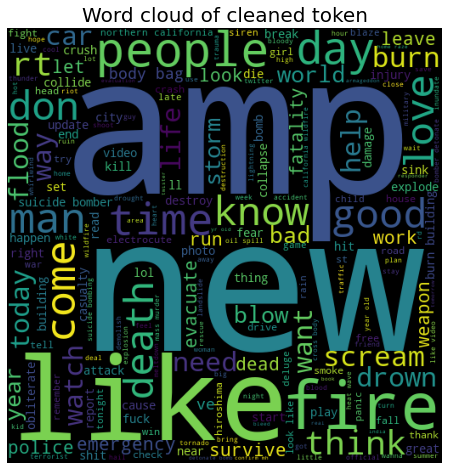

In [70]:
wordcloud(new_train["clean_token"],"Word cloud of cleaned token")

 ##### It seems that we still have some "common" words (like, know, come...) and some "weird" word as "amp" wich is the result of "&amp" partial tweet cleaning.


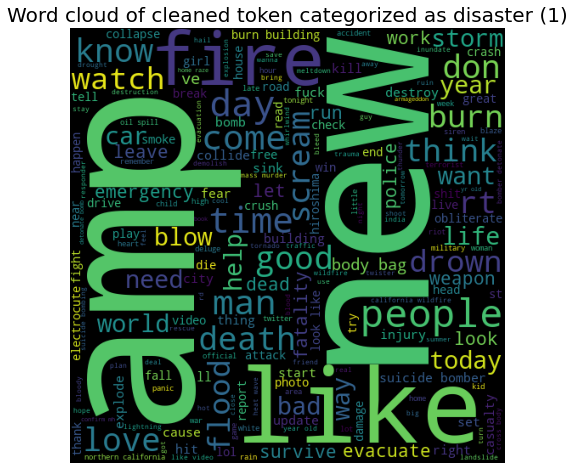

In [71]:
# Wordcloud on clean_token categorized as disaster (1)
wordcloud(new_train[new_train["clean_token"] == 1],"Word cloud of cleaned token categorized as disaster (1)")

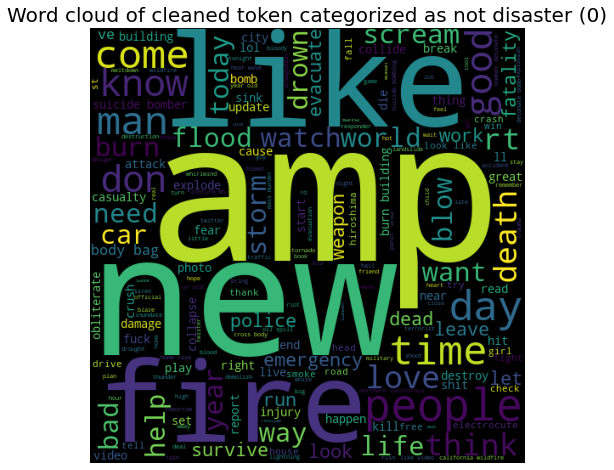

In [72]:
# Wordcloud on clean_token categorized as not disaster (1)
wordcloud(new_train[new_train["clean_token"] == 0],"Word cloud of cleaned token categorized as not disaster (0)")

##### Cleaned token still contains some unnecessary words (like, amp...) that aren't relevant and can confuse our model, which could resulting in false prediction. Based on above wordclouds, some words with high frequency will be removed from clean_token.

In [73]:
# Remove additional words

remove_words = ['like', 'amp']

def token_cleaning(data):
    return ' '.join(i for i in data.split() if i not in remove_words)

new_train["clean_token"] = new_train["clean_token"].apply(token_cleaning)

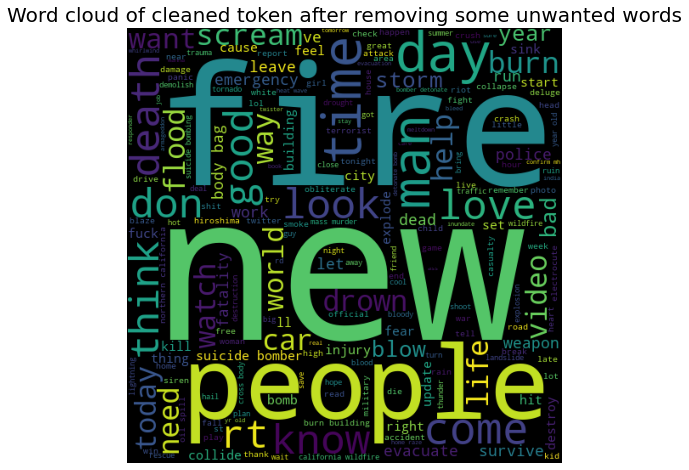

In [74]:
# Wordcloud after removing unwanted words
wordcloud(new_train["clean_token"],"Word cloud of cleaned token after removing some unwanted words")

In [75]:
# Unique words count in clean_token
uniqueWordCount = 0
count = {}
for word in new_train["clean_token"]:
   if word in count :
      count[word] += 1
   else:
      count[word] = 1
len(count)

5820

##### We have about 5800 unique words within the cleaned token column.

In [76]:
# Check if we have rows with 0 word
new_train.loc[new_train['word_count_clean_token'] == 0]

,text,target,text_clean,clean_token,word_count_text_clean,word_count_clean_token


In [77]:
new_train.head()

,text,target,text_clean,clean_token,word_count_text_clean,word_count_clean_token
0,bbc r5live studio discussion of hiroshima v po...,1,bbc r live studio discussion of hiroshima v po...,bbc r live studio discussion hiroshima v poor ...,23,18
1,@JustineJayyy OHGOD XD I didn't mean it so =P ...,0,ohgod xd i didn t mean it so p but you have t...,ohgod xd didn t mean p fire truck good xd,30,12
2,@_dmerida my tears drowned out the terrible ta...,0,dmerida my tears drowned out the terrible tas...,dmerida tear drown terrible taste nataly give ...,22,13
3,Mortal Kombat X: All Fatalities On Meat Predat...,0,mortal kombat x all fatalities on meat predator,mortal kombat x fatality meat predator,9,6
4,Bitch done blew my shit up,0,bitch done blew my shit up,bitch blow shit,6,3


## > Vectorization of cleaned token/text
---

In [78]:
# Create TF-IDF vector >> vectorize the cleaned token

vectorizer = TfidfVectorizer(ngram_range=(1,1)) # unigrams
X = vectorizer.fit_transform(new_train["clean_token"])

In [79]:
# X is a generator, we can transform it as an array

dense = X.toarray()
dense

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [80]:
# Dimensions of dense
dense.shape

(6542, 10661)

In [81]:
# Get tokens for all documents >> word and its column index
vectorizer.vocabulary_

{'bbc': 782,
 'live': 5449,
 'studio': 9005,
 'discussion': 2549,
 'hiroshima': 4288,
 'poor': 7203,
 'sheer': 8377,
 'luck': 5570,
 'cold': 1804,
 'war': 10193,
 'result': 7821,
 'catastrophe': 1473,
 'mad': 5612,
 'red': 7656,
 'herring': 4239,
 'scraptrident': 8218,
 'ohgod': 6620,
 'xd': 10528,
 'didn': 2497,
 'mean': 5815,
 'fire': 3396,
 'truck': 9711,
 'good': 3875,
 'dmerida': 2614,
 'tear': 9276,
 'drown': 2730,
 'terrible': 9329,
 'taste': 9245,
 'nataly': 6284,
 'give': 3818,
 'steak': 8895,
 'cheese': 1592,
 'thing': 9405,
 'cheer': 1591,
 'mortal': 6126,
 'kombat': 5160,
 'fatality': 3284,
 'meat': 5820,
 'predator': 7275,
 'bitch': 961,
 'blow': 1024,
 'shit': 8404,
 'swear': 9150,
 'secret': 8251,
 'll': 5465,
 'uncover': 9849,
 'old': 6646,
 'god': 3858,
 'slumber': 8592,
 'think': 9407,
 'go': 3853,
 'to': 9509,
 'blight': 1000,
 'louis': 5545,
 'sad': 8071,
 'cancel': 1382,
 'leave': 5313,
 'evacuate': 3093,
 'read': 7600,
 'eyewitness': 3211,
 'account': 55,
 'day': 

# **Machine Learning - LogisticRegression**

---


## > Baseline model
---

In [82]:
# Separate X (=features) and y (=target)
X = dense
y = new_train["target"]

In [83]:
# Divide 'dataset' into train and 'validation' sets

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=5, stratify=y)
y_train = np.array(y_train)
y_valid = np.array(y_valid)

In [84]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((4579, 10661), (1963, 10661), (4579,), (1963,))

In [85]:
# LogisticRegression model on train set

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

In [86]:
# Predictions on train set

y_train_pred = classifier.predict(X_train)

In [87]:
# Predictions on 'validation' set

y_valid_pred = classifier.predict(X_valid)

In [88]:
# Print score

print("-----------------------------------------")
print("accuracy on train set : ", accuracy_score(y_train, y_train_pred))
print("accuracy on 'validation' set : ", accuracy_score(y_valid, y_valid_pred))
print("-----------------------------------------")
print("f1_score on train set : ", f1_score(y_train, y_train_pred))
print("f1_score on 'validation' set : ", f1_score(y_valid, y_valid_pred))
print("-----------------------------------------")

-----------------------------------------
accuracy on train set :  0.9021620441144355
accuracy on 'validation' set :  0.782475802343352
-----------------------------------------
f1_score on train set :  0.8979498861047835
f1_score on 'validation' set :  0.7700592353257942
-----------------------------------------


<function matplotlib.pyplot.show>

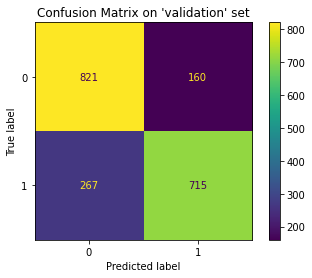

In [89]:
# Confusion matrix - Values

_ , ax = plt.subplots()
ax.set(title = "Confusion Matrix on 'validation' set")
ConfusionMatrixDisplay.from_estimator(classifier, X_valid, y_valid, ax=ax)
plt.show

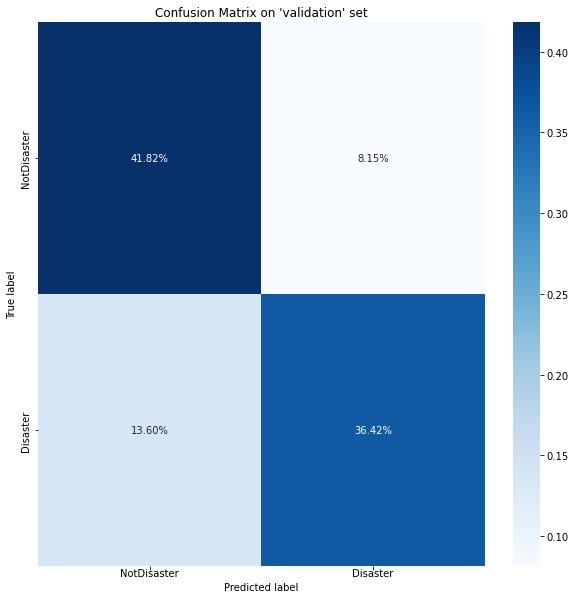

In [94]:
# Confusion matrix - Percentages 

plt.figure(figsize=(10,10))
cf_matrix = confusion_matrix(y_valid, y_valid_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.yticks([0.5,1.5], ['NotDisaster', 'Disaster'],va='center')
plt.ylabel('True label')
plt.xticks([0.5,1.5], ['NotDisaster', 'Disaster'],va='center')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix on 'validation' set")
plt.show()

## > Search best parameters

In [91]:
# Search for best parameters

classifier_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}
classifier_search = GridSearchCV(classifier, param_grid = classifier_param_grid, verbose = 3, cv=5)

# Fitting the model for grid search 
classifier_search.fit(X_train , y_train)
classifier_search.best_params_
# summarize
print('Mean Accuracy: {}'.format(classifier_search.best_score_))
print('Config: {}'.format(classifier_search.best_params_))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ...........................C=0.001;, score=0.763 total time=   0.6s
[CV 2/5] END ...........................C=0.001;, score=0.767 total time=   1.2s
[CV 3/5] END ...........................C=0.001;, score=0.771 total time=   0.8s
[CV 4/5] END ...........................C=0.001;, score=0.743 total time=   1.0s
[CV 5/5] END ...........................C=0.001;, score=0.788 total time=   0.5s
[CV 1/5] END ............................C=0.01;, score=0.783 total time=   0.7s
[CV 2/5] END ............................C=0.01;, score=0.782 total time=   0.7s
[CV 3/5] END ............................C=0.01;, score=0.794 total time=   0.7s
[CV 4/5] END ............................C=0.01;, score=0.750 total time=   0.7s
[CV 5/5] END ............................C=0.01;, score=0.786 total time=   0.8s
[CV 1/5] END .............................C=0.1;, score=0.786 total time=   1.0s
[CV 2/5] END .............................C=0.1;,

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/5] END .............................C=100;, score=0.743 total time=   9.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/5] END .............................C=100;, score=0.764 total time=   9.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/5] END .............................C=100;, score=0.760 total time=   9.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/5] END .............................C=100;, score=0.753 total time=   9.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/5] END .............................C=100;, score=0.756 total time=   9.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/5] END ............................C=1000;, score=0.731 total time=   8.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/5] END ............................C=1000;, score=0.750 total time=  10.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/5] END ............................C=1000;, score=0.757 total time=   9.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/5] END ............................C=1000;, score=0.743 total time=   9.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/5] END ............................C=1000;, score=0.753 total time=   9.3s
Mean Accuracy: 0.7848908296943231
Config: {'C': 1}
